In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import os

In [2]:
import dask.dataframe as dd
import os

# Define MIMIC-III dataset folder
MIMIC_PATH = "../mimic"

# Define file paths
ADMISSIONS_FILE = os.path.join(MIMIC_PATH, "ADMISSIONS.csv")
ICUSTAYS_FILE = os.path.join(MIMIC_PATH, "ICUSTAYS.csv")
PATIENTS_FILE = os.path.join(MIMIC_PATH, "PATIENTS.csv")
LABEVENTS_FILE = os.path.join(MIMIC_PATH, "LABEVENTS.csv")
D_ITEMS_FILE = os.path.join(MIMIC_PATH, "D_ITEMS.csv")
CHARTEVENTS_FILE = os.path.join(MIMIC_PATH, "CHARTEVENTS.csv")
OUTPUTEVENTS_FILE = os.path.join(MIMIC_PATH, "OUTPUTEVENTS.csv")
INPUTEVENTS_MV_FILE = os.path.join(MIMIC_PATH, "INPUTEVENTS_MV.csv")

print("🚀 Loading MIMIC-III Data with Dask...")

# 🔹 **Explicitly define data types (fix ambiguous columns)**
dtype_mapping = {
    "SUBJECT_ID": "int64",
    "HADM_ID": "float64",
    "ICUSTAY_ID": "float64",
    "ACTUALHOSPITALMORTALITY": "int64",
    "AGE": "float64",
    "GENDER": "object",  # Gender is categorical (M/F)
    "VALUE": "object",  # Some values might be text (e.g., 'ART')
    "ITEMID": "int64",  # Lab Test IDs should be integers
    "VALUENUM": "float64",  # Ensure numeric lab values
    "CHARTTIME": "object"  # Timestamp should be parsed separately
}

# 🔹 **Load CSV files with correct dtypes**
admissions_df = dd.read_csv(ADMISSIONS_FILE, dtype=dtype_mapping)
icu_stays_df = dd.read_csv(ICUSTAYS_FILE, dtype=dtype_mapping)
patients_df = dd.read_csv(PATIENTS_FILE, dtype=dtype_mapping)
d_items = pd.read_csv(D_ITEMS_FILE, usecols=["ITEMID", "LABEL"])

# Handle lab events separately to parse dates
lab_df = dd.read_csv(
    LABEVENTS_FILE,
    usecols=["SUBJECT_ID", "ITEMID", "CHARTTIME", "VALUENUM"],
    dtype={"SUBJECT_ID": "int64", "ITEMID": "int64", "VALUENUM": "object"},  # Handle potential text values
    parse_dates=["CHARTTIME"],
    low_memory=False
)

# Convert `VALUENUM` to numeric safely (non-numeric values become NaN)
lab_df["VALUENUM"] = dd.to_numeric(lab_df["VALUENUM"], errors="coerce")

# Load Vitals from CHARTEVENTS
vitals_df = dd.read_csv(CHARTEVENTS_FILE, usecols=["SUBJECT_ID", "ITEMID", "VALUENUM"], low_memory=False)

# Load Output Events (e.g., urine output)
output_df = dd.read_csv(OUTPUTEVENTS_FILE, usecols=["SUBJECT_ID", "ITEMID", "VALUE"], dtype={"VALUE": "object"})

# Convert `VALUE` to numeric safely (ignores non-numeric values)
output_df["VALUE"] = dd.to_numeric(output_df["VALUE"], errors="coerce")

# Load Chart Events (repeated CHARTEVENTS for additional processing)
chart_df = dd.read_csv(CHARTEVENTS_FILE, usecols=["SUBJECT_ID", "ITEMID", "VALUENUM"], low_memory=False)

# Load Patient Weight from Input Events
inputevents_df = dd.read_csv(INPUTEVENTS_MV_FILE, usecols=["SUBJECT_ID", "PATIENTWEIGHT"])

print("✅ MIMIC-III Data Successfully Loaded with Correct Data Types!")

🚀 Loading MIMIC-III Data with Dask...
✅ MIMIC-III Data Successfully Loaded with Correct Data Types!


In [3]:
motor_items = d_items[d_items["LABEL"].str.contains("motor", case=False, na=False)]

print("🧠 GCS Motor-related ITEMIDs:")
print(motor_items)

🧠 GCS Motor-related ITEMIDs:
       ITEMID                  LABEL
680       453         Motor Deficits
681       454         Motor Response
8758   227120          Motor Deficit
9680   227012      GCSMotor_ApacheIV
9746   228404            Motor L Arm
9747   228405            Motor L Leg
9748   228406            Motor R Arm
9749   228407            Motor R Leg
12038  223901   GCS - Motor Response
12482  226757  GCSMotorApacheIIValue


In [4]:
print("🚀 Processing ICU Admissions & Mortality Data...")

# Ensure SUBJECT_ID is consistently named as PATIENT_ID
icu_stays_df = icu_stays_df.rename(columns={"SUBJECT_ID": "PATIENT_ID"})
admissions_df = admissions_df.rename(columns={"SUBJECT_ID": "PATIENT_ID"})

# Convert ADMITTIME to datetime format
admissions_df["ADMITTIME"] = dd.to_datetime(admissions_df["ADMITTIME"], errors="coerce")

# Ensure data types match before merging (avoid float64/int64 warnings)
admissions_df["PATIENT_ID"] = admissions_df["PATIENT_ID"].astype("int64")
admissions_df["HADM_ID"] = admissions_df["HADM_ID"].astype("int64")

icu_stays_df["PATIENT_ID"] = icu_stays_df["PATIENT_ID"].astype("int64")
icu_stays_df["HADM_ID"] = icu_stays_df["HADM_ID"].astype("int64")

# Merge ICU stays with admissions data on PATIENT_ID and HADM_ID
mimic_df = icu_stays_df.merge(admissions_df, on=["PATIENT_ID", "HADM_ID"], how="left")


# Rename hospital mortality flag for clarity
mimic_df = mimic_df.rename(columns={"HOSPITAL_EXPIRE_FLAG": "actualhospitalmortality"})

print("✅ ICU Admissions & Mortality Data Merged Successfully with Dask!")

🚀 Processing ICU Admissions & Mortality Data...
✅ ICU Admissions & Mortality Data Merged Successfully with Dask!


In [5]:
icu_stays_df.columns

Index(['ROW_ID', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')

In [6]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [7]:
# Convert Dask to Pandas
print("🔄 Converting Dask DataFrame to Pandas...")
mimic_df = mimic_df.compute()
print("✅ Converted to Pandas!")

🔄 Converting Dask DataFrame to Pandas...
✅ Converted to Pandas!


In [8]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [9]:
mimic_df = dd.from_pandas(mimic_df, npartitions=4)

In [10]:
print("🚀 Extracting & Processing Gender & Age...")

# Ensure SUBJECT_ID is consistently named as PATIENT_ID
patients_df = patients_df.rename(columns={"SUBJECT_ID": "PATIENT_ID"})

# Convert DOB and ADMITTIME to datetime format
patients_df["DOB"] = dd.to_datetime(patients_df["DOB"], errors="coerce")
admissions_df["ADMITTIME"] = dd.to_datetime(admissions_df["ADMITTIME"], errors="coerce")

# Ensure data types match before merging
patients_df["PATIENT_ID"] = patients_df["PATIENT_ID"].astype("int64")
admissions_df["PATIENT_ID"] = admissions_df["PATIENT_ID"].astype("int64")

# Merge DOB with admissions to calculate AGE
patients_df = patients_df.merge(admissions_df[["PATIENT_ID", "ADMITTIME"]], on="PATIENT_ID", how="left")

# Compute age (year difference)
patients_df["AGE"] = patients_df["ADMITTIME"].dt.year - patients_df["DOB"].dt.year

# Handle de-identified ages (MIMIC marks ages >= 300 as unknown → Set to 90)
patients_df["AGE"] = patients_df["AGE"].map(lambda x: 90 if x >= 300 else x, meta=("AGE", "int64"))

# Convert `GENDER` to numeric format (M=1, F=0)
patients_df["GENDER"] = patients_df["GENDER"].map({"M": 1, "F": 0}, meta=("GENDER", "int64"))

# Drop unnecessary columns before merging
patients_df = patients_df.drop(columns=["DOB", "ADMITTIME"])

# Merge Gender & Age into main dataset
mimic_df = mimic_df.merge(patients_df, on="PATIENT_ID", how="left")

print("✅ Gender & Age Features Added Successfully with Dask!")

🚀 Extracting & Processing Gender & Age...
✅ Gender & Age Features Added Successfully with Dask!


In [11]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'GENDER',
       'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'AGE'],
      dtype='object')

In [12]:
import dask.dataframe as dd
import pandas as pd
import os

# 📁 Define MIMIC-III dataset path
MIMIC_PATH = "../mimic"
LABEVENTS_FILE = os.path.join(MIMIC_PATH, "LABEVENTS.csv")

print("🚀 Loading & Processing Lab Test Data...")

# 🧪 Load Lab Events Data
lab_df = dd.read_csv(
    LABEVENTS_FILE,
    usecols=["SUBJECT_ID", "ITEMID", "CHARTTIME", "VALUENUM"],
    dtype={"SUBJECT_ID": "int64", "ITEMID": "int64", "VALUENUM": "float64"},
    parse_dates=["CHARTTIME"],
    low_memory=False
)

# 🔹 Step 1: Define Lab Test Mapping
lab_mapping = {
    50912: "CREATININE", 50862: "ALBUMIN", 50821: "PAO2", 50818: "PCO2",
    51006: "BUN", 50931: "GLUCOSE", 50885: "BILIRUBIN",
    50983: "SODIUM", 50820: "PH", 51300: "WBC", 50971: "Potassium",
    51222: "Hemoglobin", 51265: "PLATELET"  ,  50813: "LACTATE",  
    50902: "CHLORIDE" 
}

# 🔹 Step 2: Map ITEMID to lab names & filter
lab_df["LABNAME"] = lab_df["ITEMID"].map(lab_mapping, meta=("LABNAME", "str"))
lab_df = lab_df.dropna(subset=["LABNAME"])
lab_df["LABNAME"] = lab_df["LABNAME"].astype("category")

# 🔹 Step 3: Compute Mean Lab Values per Patient & Lab
lab_mean_dd = lab_df.groupby(["SUBJECT_ID", "LABNAME"])["VALUENUM"].mean()
lab_mean = lab_mean_dd.compute().reset_index()

# 🔹 Step 4: Safe Pivot using pivot_table (handles duplicates)
lab_mean = lab_mean.pivot_table(index="SUBJECT_ID", columns="LABNAME", values="VALUENUM", aggfunc="mean").reset_index()

# 🔹 Step 5: Rename for consistency
lab_mean = lab_mean.rename(columns={"SUBJECT_ID": "PATIENT_ID", "PH": "mean_pH", "BUN": "mean_BUN", "GLUCOSE": "mean_GLUCOSE"})

# 🔹 Step 6: Extract First Values for PH, BUN, GLUCOSE
lab_sub = lab_df[lab_df["LABNAME"].isin(["PH", "BUN", "GLUCOSE"])][["SUBJECT_ID", "LABNAME", "CHARTTIME", "VALUENUM"]]
lab_sub = lab_sub.compute().sort_values(by=["SUBJECT_ID", "LABNAME", "CHARTTIME"])
first_labs = lab_sub.groupby(["SUBJECT_ID", "LABNAME"]).first().reset_index()
first_labs = first_labs.pivot(index="SUBJECT_ID", columns="LABNAME", values="VALUENUM").reset_index()
first_labs = first_labs.rename(columns={"SUBJECT_ID": "PATIENT_ID", "PH": "ph", "BUN": "bun", "GLUCOSE": "glucose"})

# 🔹 Step 7: Merge mean + first values to get final lab data
lab_final = pd.merge(lab_mean, first_labs, on="PATIENT_ID", how="left")

print("✅ Lab Test Data Processed Successfully!")
print(lab_final[["PATIENT_ID", "mean_pH", "ph", "mean_BUN", "bun", "mean_GLUCOSE", "glucose"]].head())

# 🔁 Remove any existing lab columns in mimic_df that also exist in lab_final (ignoring suffixes)
# Build a set of lab column names from lab_final, excluding "PATIENT_ID"
lab_cols = set(lab_final.columns) - {"PATIENT_ID"}

cols_to_drop = []
for col in mimic_df.columns:
    # If the column exactly matches a lab column
    if col in lab_cols:
        cols_to_drop.append(col)
    # Also drop if the column ends with _x or _y and its base name is a lab column
    elif (col.endswith("_x") or col.endswith("_y")) and col[:-2] in lab_cols:
        cols_to_drop.append(col)

mimic_df = mimic_df.drop(columns=cols_to_drop)
print("Columns dropped:", cols_to_drop)

# ✅ Now safely merge the lab data into mimic_df
mimic_df = mimic_df.merge(lab_final, on="PATIENT_ID", how="left")
print("✅ Lab Data Merged Without _x/_y Duplicates!")

🚀 Loading & Processing Lab Test Data...


/Users/parthshiroya/anaconda3/lib/python3.11/site-packages/dask/dataframe/dask_expr/_groupby.py:1561: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/var/folders/qb/06xhfcmx5yzc7t8swxtczfpw0000gn/T/ipykernel_90559/3908468552.py:39: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lab_mean = lab_mean.pivot_table(index="SUBJECT_ID", columns="LABNAME", values="VALUENUM", aggfunc="mean").reset_index()


✅ Lab Test Data Processed Successfully!
LABNAME  PATIENT_ID   mean_pH    ph   mean_BUN   bun  mean_GLUCOSE  glucose
0                 2       NaN   NaN        NaN   NaN           NaN      NaN
1                 3  7.388958  7.44  33.236842  42.0    121.714286    121.0
2                 4  7.396667  7.47  16.754717   9.0    146.294118    140.0
3                 5       NaN   NaN        NaN   NaN           NaN      NaN
4                 6  7.342000  7.39  38.500000  63.0    117.250000    112.0
Columns dropped: []
✅ Lab Data Merged Without _x/_y Duplicates!


/var/folders/qb/06xhfcmx5yzc7t8swxtczfpw0000gn/T/ipykernel_90559/3908468552.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_labs = lab_sub.groupby(["SUBJECT_ID", "LABNAME"]).first().reset_index()


In [13]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'GENDER',
       'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'AGE', 'ALBUMIN_x',
       'BILIRUBIN_x', 'mean_BUN', 'CHLORIDE_x', 'CREATININE_x', 'mean_GLUCOSE',
       'Hemoglobin_x', 'LACTATE_x', 'PAO2_x', 'PCO2_x', 'mean_pH',
       'PLATELET_x', 'Potassium_x', 'SODIUM_x', 'WBC_x', 'ALBUMIN_y',
       'BILIRUBIN_y', 'bun', 'CHLORIDE_y', 'CREATININE_y', 'glucose',
       'Hemoglobin_y', 'LACTATE_y', 'PAO2_y', 'PCO2_y', 'ph', 'PLATELET_y',
       'Potassium_y', 'SODIUM_y', 'WBC_y'],
      dtype='object')

In [14]:
mimic_df = mimic_df.drop(columns=['HEMATOCRIT_y',
       'Hemoglobin_y', 'PAO2_y', 'PCO2_y', 'PLATELET_y', 'Potassium_y',
       'SODIUM_y', 'WBC_y','ALBUMIN_y',
       'BILIRUBIN_y',  'CREATININE_y','LACTATE_y','CHLORIDE_y'], errors="ignore")

In [15]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'GENDER',
       'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'AGE', 'ALBUMIN_x',
       'BILIRUBIN_x', 'mean_BUN', 'CHLORIDE_x', 'CREATININE_x', 'mean_GLUCOSE',
       'Hemoglobin_x', 'LACTATE_x', 'PAO2_x', 'PCO2_x', 'mean_pH',
       'PLATELET_x', 'Potassium_x', 'SODIUM_x', 'WBC_x', 'bun', 'glucose',
       'ph'],
      dtype='object')

In [16]:
# Define mapping for vital signs
vitals_mapping = {
    220045: "HEARTRATE", 
    220050: "SYSTOLIC_BP", 
    220051: "DIASTOLIC_BP",
    220052: "MEAN_BP",
    220210: "RESPIRATORYRATE",
    224690: "RESPIRATION",
    223762: "TEMPERATURE",
    220277: "SAO2",
    454: "motor",         # GSR Motor CareVue
    223901: "motor"       # GSR Motor MetaVision
}

# Map `ITEMID` to meaningful names
vitals_df["VITALNAME"] = vitals_df["ITEMID"].map(vitals_mapping, meta=("VITALNAME", "object"))

# 🔹 **Filter for only mapped vital signs**
vitals_df = vitals_df.dropna(subset=["VITALNAME"])

# Convert `VITALNAME` to categorical for pivoting
vitals_df["VITALNAME"] = vitals_df["VITALNAME"].astype("category")

# Aggregate values (mean per patient & vital sign)
vitals_agg = (
    vitals_df.groupby(["SUBJECT_ID", "VITALNAME"])["VALUENUM"]
    .mean()
    .reset_index()
)

# Compute before pivoting
vitals_agg = vitals_agg.compute()

# 🔹 **Pivot the table properly using pivot_table**
vitals_agg = vitals_agg.pivot_table(index="SUBJECT_ID", columns="VITALNAME", values="VALUENUM", aggfunc="mean")

# Reset index & rename column for consistency
vitals_agg = vitals_agg.reset_index().rename(columns={"SUBJECT_ID": "PATIENT_ID"})

print("✅ Vital Signs Data Processed Successfully!")

# Merge vitals into main dataset
mimic_df = mimic_df.merge(vitals_agg, on="PATIENT_ID", how="left")

/Users/parthshiroya/anaconda3/lib/python3.11/site-packages/dask/dataframe/dask_expr/_groupby.py:1561: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


✅ Vital Signs Data Processed Successfully!


In [17]:
# Define urine output ITEMIDs based on MIMIC documentation
urine_item_ids = [
    40055,  # Urine Output (Total)
    43175,  # Urine Output 6hr
    40069,  # Urine Output 24hr
    40094,  # Urine Output 8hr
    40715,  # Urine Output (All)
    40473,  # Urine Output (12hr)
    40405,  # Urine Output (Post Void)
    40428,  # Urine Output (Before Sample)
    40085,  # Foley Catheter Output
]

# Filter only relevant urine output records
urine_df = output_df[output_df["ITEMID"].isin(urine_item_ids)]

# Aggregate total urine output per patient
urine_agg = urine_df.groupby("SUBJECT_ID")["VALUE"].sum().reset_index()

# Rename columns for consistency
urine_agg = urine_agg.rename(columns={"SUBJECT_ID": "PATIENT_ID", "VALUE": "URINE_OUTPUT"})

print("✅ Urine Output Data Processed Successfully!")

# Merge urine output into main dataset
mimic_df = mimic_df.merge(urine_agg, on="PATIENT_ID", how="left")

print("✅ Urine Output Successfully Merged into MIMIC-III Dataset!")

✅ Urine Output Data Processed Successfully!
✅ Urine Output Successfully Merged into MIMIC-III Dataset!


In [18]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'GENDER',
       'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'AGE', 'ALBUMIN_x',
       'BILIRUBIN_x', 'mean_BUN', 'CHLORIDE_x', 'CREATININE_x', 'mean_GLUCOSE',
       'Hemoglobin_x', 'LACTATE_x', 'PAO2_x', 'PCO2_x', 'mean_pH',
       'PLATELET_x', 'Potassium_x', 'SODIUM_x', 'WBC_x', 'bun', 'glucose',
       'ph', 'DIASTOLIC_BP', 'HEARTRATE', 'MEAN_BP', 'RESPIRATION',
       'RESPIRATORYRATE', 'SAO2', 'SYSTOLIC_BP', 'TEMPERATURE', 'motor',
       'URINE_OUTPUT'],
      dtype='object')

In [20]:
import pandas as pd

# Load OUTPUTEVENTS.csv
outputevents_path = "../mimic/OUTPUTEVENTS.csv"
output_df = pd.read_csv(outputevents_path, usecols=["SUBJECT_ID", "ITEMID", "VALUE"], low_memory=False)

# Convert VALUE to numeric
output_df["VALUE"] = pd.to_numeric(output_df["VALUE"], errors="coerce")
output_df = output_df.dropna(subset=["VALUE"])

# Calculate mean output per patient
output_mean_df = output_df.groupby("SUBJECT_ID")["VALUE"].mean().reset_index()
output_mean_df = output_mean_df.rename(columns={"SUBJECT_ID": "PATIENT_ID", "VALUE": "outputtotal_mean"})

# Merge into your main MIMIC DataFrame
mimic_df = mimic_df.merge(output_mean_df, on="PATIENT_ID", how="left")

print("✅ outputtotal_mean added to mimic_df!")

✅ outputtotal_mean added to mimic_df!


In [21]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'actualhospitalmortality', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'GENDER',
       'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'AGE', 'ALBUMIN_x',
       'BILIRUBIN_x', 'mean_BUN', 'CHLORIDE_x', 'CREATININE_x', 'mean_GLUCOSE',
       'Hemoglobin_x', 'LACTATE_x', 'PAO2_x', 'PCO2_x', 'mean_pH',
       'PLATELET_x', 'Potassium_x', 'SODIUM_x', 'WBC_x', 'bun', 'glucose',
       'ph', 'DIASTOLIC_BP', 'HEARTRATE', 'MEAN_BP', 'RESPIRATION',
       'RESPIRATORYRATE', 'SAO2', 'SYSTOLIC_BP', 'TEMPERATURE', 'motor',
       'URINE_OUTPUT', 'outputtotal_mean'],
      dtype='object')

In [38]:
import pandas as pd

# Load INPUTEVENTS_MV.csv
inputevents_path = "../mimic/INPUTEVENTS_MV.csv"
input_df = pd.read_csv(inputevents_path, usecols=["SUBJECT_ID", "AMOUNT"], low_memory=False)

# Convert AMOUNT to numeric
input_df["AMOUNT"] = pd.to_numeric(input_df["AMOUNT"], errors="coerce")
input_df = input_df.dropna(subset=["AMOUNT"])

# Compute mean intake per patient
input_mean_df = input_df.groupby("SUBJECT_ID")["AMOUNT"].mean().reset_index()
input_mean_df = input_mean_df.rename(columns={"SUBJECT_ID": "PATIENT_ID", "AMOUNT": "intaketotal_mean"})

# Merge into main mimic_df
mimic_df = mimic_df.merge(input_mean_df, on="PATIENT_ID", how="left")

print("✅ intaketotal_mean added to mimic_df!")

✅ intaketotal_mean added to mimic_df!


In [39]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID',
       'LAST_WARDID', 'LOS_days', 'ROW_ID_y', 'HAS_CHARTEVENTS_DATA', 'ROW_ID',
       'gender', 'EXPIRE_FLAG', 'age', 'albumin', 'mean_total bilirubin',
       'mean_BUN', 'mean_chloride', 'mean_creatinine', 'mean_glucose',
       'mean_Hgb', 'mean_lactate', 'mean_paO2', 'mean_paCO2', 'mean_pH',
       'mean_platelets x 1000', 'mean_potassium', 'mean_sodium',
       'mean_WBC x 1000', 'bun', 'glucose', 'ph', 'systemicdiastolic',
       'heartrate', 'systemicmean', 'respiration', 'respiratoryrate', 'sao2',
       'systemicsystolic', 'temperature', 'motor', 'urine', 'outputtotal_mean',
       'actualhospitalmortality', 'intaketotal_mean'],
      dtype='object')

In [61]:
inputevents_df = inputevents_df.rename(columns={"SUBJECT_ID": "PATIENT_ID"})
input_weight_df = inputevents_df.groupby("PATIENT_ID")["PATIENTWEIGHT"].mean().reset_index()


# Ensure input_weight_df is Pandas
if not isinstance(input_weight_df, pd.DataFrame):
    input_weight_df = input_weight_df.compute()

# Perform merge
mimic_df = mimic_df.merge(input_weight_df, on="PATIENT_ID", how="left")

In [62]:
mimic_df.columns

Index(['ROW_ID_x', 'PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID',
       'LAST_WARDID', 'LOS_days', 'ROW_ID_y', 'HAS_CHARTEVENTS_DATA', 'ROW_ID',
       'gender', 'EXPIRE_FLAG', 'age', 'albumin', 'mean_total bilirubin',
       'mean_BUN', 'mean_chloride', 'mean_creatinine', 'mean_glucose',
       'mean_Hgb', 'mean_lactate', 'mean_paO2', 'mean_paCO2', 'mean_pH',
       'mean_platelets x 1000', 'mean_potassium', 'mean_sodium',
       'mean_WBC x 1000', 'bun', 'glucose', 'ph', 'systemicdiastolic',
       'heartrate', 'systemicmean', 'respiration', 'respiratoryrate', 'sao2',
       'systemicsystolic', 'temperature', 'motor', 'urine', 'outputtotal_mean',
       'intaketotal_mean', 'actualhospitalmortality', 'PATIENTWEIGHT'],
      dtype='object')

In [63]:
mimic_df = mimic_df.drop(columns=["ROW_ID_x", "ROW_ID_y","ROW_ID"], errors="ignore")

In [64]:
mimic_df.columns

Index(['PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID', 'LAST_WARDID',
       'LOS_days', 'HAS_CHARTEVENTS_DATA', 'gender', 'EXPIRE_FLAG', 'age',
       'albumin', 'mean_total bilirubin', 'mean_BUN', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_Hgb', 'mean_lactate',
       'mean_paO2', 'mean_paCO2', 'mean_pH', 'mean_platelets x 1000',
       'mean_potassium', 'mean_sodium', 'mean_WBC x 1000', 'bun', 'glucose',
       'ph', 'systemicdiastolic', 'heartrate', 'systemicmean', 'respiration',
       'respiratoryrate', 'sao2', 'systemicsystolic', 'temperature', 'motor',
       'urine', 'outputtotal_mean', 'intaketotal_mean',
       'actualhospitalmortality', 'PATIENTWEIGHT'],
      dtype='object')

KeyError: "['admitdiagnosis', 'mean_chloride', 'mean_lactate', 'systemicmean', 'ventstartoffset'] not in index"

In [65]:
# Define a mapping to align column names
feature_mapping = {
    "AGE": "age",
    "PATIENTWEIGHT": "admissionweight",
    "URINE_OUTPUT": "urine",
    "WBC_x": "mean_WBC x 1000",
    "RESPIRATORYRATE": "respiratoryrate",
    "RESPIRATION": "respiration",
    "SODIUM_x": "mean_sodium",
    "MEAN_BP": "systemicmean",
    "mean_pH": "mean_pH",
    "CREATININE_x": "mean_creatinine",
    "ALBUMIN_x": "albumin",
    "PAO2_x": "mean_paO2",
    "PCO2_x": "mean_paCO2",
    "mean_BUN": "mean_BUN",
    "Potassium_x": "mean_potassium",
    "mean_GLUCOSE": "mean_glucose",
    "BILIRUBIN_x": "mean_total bilirubin",
    "HEARTRATE": "heartrate",
    "TEMPERATURE": "temperature",
    "SAO2": "sao2",
    "DIASTOLIC_BP": "systemicdiastolic",
    "SYSTOLIC_BP": "systemicsystolic",
    "Hemoglobin_x": "mean_Hgb",
    "LOS": "LOS_days",
    "GENDER": "gender",
    "PLATELET_x": "mean_platelets x 1000",
    "CHLORIDE_x": "mean_chloride",
    "LACTATE_x": "mean_lactate"

}

# Rename MIMIC columns
mimic_df = mimic_df.rename(columns=feature_mapping)

In [66]:
mimic_df.columns

Index(['PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID', 'LAST_WARDID',
       'LOS_days', 'HAS_CHARTEVENTS_DATA', 'gender', 'EXPIRE_FLAG', 'age',
       'albumin', 'mean_total bilirubin', 'mean_BUN', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_Hgb', 'mean_lactate',
       'mean_paO2', 'mean_paCO2', 'mean_pH', 'mean_platelets x 1000',
       'mean_potassium', 'mean_sodium', 'mean_WBC x 1000', 'bun', 'glucose',
       'ph', 'systemicdiastolic', 'heartrate', 'systemicmean', 'respiration',
       'respiratoryrate', 'sao2', 'systemicsystolic', 'temperature', 'motor',
       'urine', 'outputtotal_mean', 'intaketotal_mean',
       'actualhospitalmortality', 'admissionweight'],
      dtype='object')

In [67]:
import dask.dataframe as dd

# Convert to Pandas if it's Dask
if isinstance(mimic_df, dd.DataFrame):
    print("🔄 Converting Dask DataFrame to Pandas...")
    mimic_df = mimic_df.compute()
else:
    print("✅ Already a Pandas DataFrame.")

✅ Already a Pandas DataFrame.


In [68]:
mimic_df.columns

Index(['PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID', 'LAST_WARDID',
       'LOS_days', 'HAS_CHARTEVENTS_DATA', 'gender', 'EXPIRE_FLAG', 'age',
       'albumin', 'mean_total bilirubin', 'mean_BUN', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_Hgb', 'mean_lactate',
       'mean_paO2', 'mean_paCO2', 'mean_pH', 'mean_platelets x 1000',
       'mean_potassium', 'mean_sodium', 'mean_WBC x 1000', 'bun', 'glucose',
       'ph', 'systemicdiastolic', 'heartrate', 'systemicmean', 'respiration',
       'respiratoryrate', 'sao2', 'systemicsystolic', 'temperature', 'motor',
       'urine', 'outputtotal_mean', 'intaketotal_mean',
       'actualhospitalmortality', 'admissionweight'],
      dtype='object')

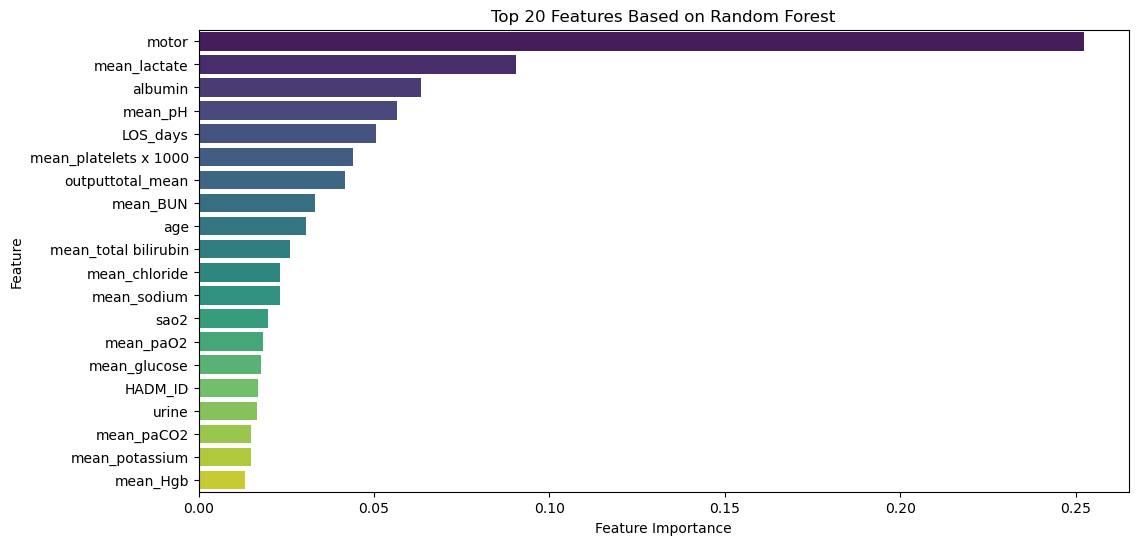

In [69]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# ✅ Ensure you're working with a DataFrame (not NumPy array)
y = mimic_df['actualhospitalmortality']  # the target column as Series or array
X = mimic_df.drop(columns=["actualhospitalmortality", "EXPIRE_FLAG"], errors='ignore')


mimic_df = mimic_df.astype({col: int for col in mimic_df.columns if mimic_df[col].dtype == 'bool'})
# ✅ Drop categorical/object columns
X_numeric = X.select_dtypes(include=["number"])

# ✅ Train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_numeric, y)

# ✅ Feature importance
feature_importances = pd.DataFrame({
    "Feature": X_numeric.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# ✅ Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(y=feature_importances["Feature"][:20], x=feature_importances["Importance"][:20], palette="viridis")
plt.title("Top 20 Features Based on Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

In [70]:
mimic_df.columns

Index(['PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID', 'LAST_WARDID',
       'LOS_days', 'HAS_CHARTEVENTS_DATA', 'gender', 'EXPIRE_FLAG', 'age',
       'albumin', 'mean_total bilirubin', 'mean_BUN', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_Hgb', 'mean_lactate',
       'mean_paO2', 'mean_paCO2', 'mean_pH', 'mean_platelets x 1000',
       'mean_potassium', 'mean_sodium', 'mean_WBC x 1000', 'bun', 'glucose',
       'ph', 'systemicdiastolic', 'heartrate', 'systemicmean', 'respiration',
       'respiratoryrate', 'sao2', 'systemicsystolic', 'temperature', 'motor',
       'urine', 'outputtotal_mean', 'intaketotal_mean',
       'actualhospitalmortality', 'admissionweight'],
      dtype='object')

mimic_df.isna.sum()

In [71]:
len(mimic_df)

116426

In [72]:
mimic_df.isna().sum()

PATIENT_ID                     0
HADM_ID                        0
ICUSTAY_ID                     0
FIRST_WARDID                   0
LAST_WARDID                    0
LOS_days                       0
HAS_CHARTEVENTS_DATA           0
gender                         0
EXPIRE_FLAG                    0
age                            0
albumin                        0
mean_total bilirubin           0
mean_BUN                       0
mean_chloride                  0
mean_creatinine                0
mean_glucose                   0
mean_Hgb                       0
mean_lactate                   0
mean_paO2                      0
mean_paCO2                     0
mean_pH                        0
mean_platelets x 1000          0
mean_potassium                 0
mean_sodium                    0
mean_WBC x 1000                0
bun                            0
glucose                        0
ph                             0
systemicdiastolic              0
heartrate                      0
systemicme

In [73]:
mimic_df.head()

,PATIENT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS_days,HAS_CHARTEVENTS_DATA,gender,EXPIRE_FLAG,age,...,respiratoryrate,sao2,systemicsystolic,temperature,motor,urine,outputtotal_mean,intaketotal_mean,actualhospitalmortality,admissionweight
0,268.0,110404.0,280836.0,52.0,52.0,3.2490,1.0,0.0,1.0,66.0,...,19.163494,98.060368,122.739111,44.218974,3.818182,530.0,42.413793,249.61401,1,NaN
1,269.0,106296.0,206613.0,52.0,52.0,3.2788,1.0,1.0,0.0,40.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,9920.0,268.108108,249.61401,0,NaN
2,270.0,188028.0,220345.0,57.0,57.0,2.8939,1.0,1.0,0.0,80.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,5805.0,223.269231,249.61401,0,NaN
3,271.0,173727.0,249196.0,52.0,23.0,2.0600,1.0,0.0,0.0,46.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,3400.0,100.000000,249.61401,0,NaN
4,272.0,164716.0,210407.0,57.0,57.0,1.6202,1.0,1.0,0.0,67.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,5625.0,208.333333,249.61401,0,NaN


In [74]:
from sklearn.impute import SimpleImputer

# Separate target
target_col = "actualhospitalmortality"
y = mimic_df[target_col]
X = mimic_df.drop(columns=[target_col])

# Keep only numeric columns (drop datetime/object/categorical)
X_numeric = X.select_dtypes(include=["number"])

# Impute numeric columns
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_numeric)

# Convert back to DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=X_numeric.columns)

# Combine imputed numeric with target
mimic_cleaned_df = X_imputed_df.copy()
mimic_cleaned_df[target_col] = y.reset_index(drop=True)

print("✅ Imputation complete and non-numeric columns excluded.")
print("📊 Final shape:", mimic_cleaned_df.shape)

✅ Imputation complete and non-numeric columns excluded.
📊 Final shape: (116426, 42)


In [75]:
mimic_df = mimic_cleaned_df

In [76]:
mimic_df.head()

,PATIENT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS_days,HAS_CHARTEVENTS_DATA,gender,EXPIRE_FLAG,age,...,respiratoryrate,sao2,systemicsystolic,temperature,motor,urine,outputtotal_mean,intaketotal_mean,admissionweight,actualhospitalmortality
0,268.0,110404.0,280836.0,52.0,52.0,3.2490,1.0,0.0,1.0,66.0,...,19.163494,98.060368,122.739111,44.218974,3.818182,530.0,42.413793,249.61401,79.573338,1
1,269.0,106296.0,206613.0,52.0,52.0,3.2788,1.0,1.0,0.0,40.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,9920.0,268.108108,249.61401,79.573338,0
2,270.0,188028.0,220345.0,57.0,57.0,2.8939,1.0,1.0,0.0,80.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,5805.0,223.269231,249.61401,79.573338,0
3,271.0,173727.0,249196.0,52.0,23.0,2.0600,1.0,0.0,0.0,46.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,3400.0,100.000000,249.61401,79.573338,0
4,272.0,164716.0,210407.0,57.0,57.0,1.6202,1.0,1.0,0.0,67.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,5625.0,208.333333,249.61401,79.573338,0


optimized_features = ['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'motor',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'LOS_days','actualhospitalmortality']

mimic_df = mimic_df[selected_features]

selected_features = ['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'motor',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'LOS_days','actualhospitalmortality']

mimic_df = mimic_df[selected_features]

In [77]:
mimic_df.head()

,PATIENT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS_days,HAS_CHARTEVENTS_DATA,gender,EXPIRE_FLAG,age,...,respiratoryrate,sao2,systemicsystolic,temperature,motor,urine,outputtotal_mean,intaketotal_mean,admissionweight,actualhospitalmortality
0,268.0,110404.0,280836.0,52.0,52.0,3.2490,1.0,0.0,1.0,66.0,...,19.163494,98.060368,122.739111,44.218974,3.818182,530.0,42.413793,249.61401,79.573338,1
1,269.0,106296.0,206613.0,52.0,52.0,3.2788,1.0,1.0,0.0,40.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,9920.0,268.108108,249.61401,79.573338,0
2,270.0,188028.0,220345.0,57.0,57.0,2.8939,1.0,1.0,0.0,80.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,5805.0,223.269231,249.61401,79.573338,0
3,271.0,173727.0,249196.0,52.0,23.0,2.0600,1.0,0.0,0.0,46.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,3400.0,100.000000,249.61401,79.573338,0
4,272.0,164716.0,210407.0,57.0,57.0,1.6202,1.0,1.0,0.0,67.0,...,19.163494,98.060368,122.739111,44.218974,6.000000,5625.0,208.333333,249.61401,79.573338,0


In [78]:
mimic_df.columns

Index(['PATIENT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID', 'LAST_WARDID',
       'LOS_days', 'HAS_CHARTEVENTS_DATA', 'gender', 'EXPIRE_FLAG', 'age',
       'albumin', 'mean_total bilirubin', 'mean_BUN', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_Hgb', 'mean_lactate',
       'mean_paO2', 'mean_paCO2', 'mean_pH', 'mean_platelets x 1000',
       'mean_potassium', 'mean_sodium', 'mean_WBC x 1000', 'bun', 'glucose',
       'ph', 'systemicdiastolic', 'heartrate', 'systemicmean', 'respiration',
       'respiratoryrate', 'sao2', 'systemicsystolic', 'temperature', 'motor',
       'urine', 'outputtotal_mean', 'intaketotal_mean', 'admissionweight',
       'actualhospitalmortality'],
      dtype='object')

In [79]:
# Estimate memory usage
mimic_df_size = mimic_df.memory_usage(deep=True).sum() / (1024 ** 3)
print(f"🚀 Estimated size of merged_df: {mimic_df_size:.2f} GB")

output_path = "merged_mimic_data.parquet"

mimic_df.to_parquet(output_path, index=False)
print(f"✅ Merged Mimic dataset saved as Parquet: {output_path}")

🚀 Estimated size of merged_df: 0.04 GB
✅ Merged Mimic dataset saved as Parquet: merged_mimic_data.parquet
